<a href="https://colab.research.google.com/github/dilshankm/amisafe-ml/blob/main/amisafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy. stats import skewnorm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, roc_auc_score,accuracy_score
import pickle
df = pd.read_csv('/content/drive/MyDrive/CMP7161/datasets/crimes.csv')

Mounted at /content/drive


# EDA

In [ ]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())

Dataset Shape: (6671452, 12)

Columns: ['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type', 'Last outcome category', 'Context']

Missing Values:
 Crime ID                 1055193
Month                          0
Reported by                    0
Falls within                   0
Longitude                  95393
Latitude                   95393
Location                       0
LSOA code                  96991
LSOA name                  96991
Crime type                     0
Last outcome category    1055193
Context                  6671452
dtype: int64

Duplicate Rows: 328664


In [ ]:
# Check partial duplicates (for transparency)
partial_duplicates = df.duplicated(
    subset=["Month", "Location", "Crime type", "Longitude", "Latitude"]
).sum()
print(f"Partial duplicates (same crime + location + coordinates): {partial_duplicates}")

Partial duplicates (same crime + location + coordinates): 2079468


In [ ]:
# Investigate these duplicates before deciding to remove them
duplicate_sample = df[df.duplicated(
    subset=["Month", "Location", "Crime type", "Longitude", "Latitude"], keep=False
)].sort_values(["Month", "Location", "Crime type"])
print(duplicate_sample.head(100))

                                                 Crime ID    Month  \
28249                                                 NaN  2024-01   
34902                                                 NaN  2024-01   
34903                                                 NaN  2024-01   
93330                                                 NaN  2024-01   
288906                                                NaN  2024-01   
...                                                   ...      ...   
13397   f297b312c4dc236eefb102784896f295bc8ee5c6a9f99f...  2024-01   
13398   f7172d331feb0fb67567e3338c5f772bd7867e08e6f3ce...  2024-01   
13399   38ac5d52921e16dccd59e83299bd6816c921211ecb1509...  2024-01   
13400   fc7851d6dde76311953cc56fd849d120852be0386c8158...  2024-01   
13401   ddbd46d4a04844dc1d08048172dfcc805b31d98c5c1426...  2024-01   

                           Reported by                    Falls within  \
28249      Cambridgeshire Constabulary     Cambridgeshire Constabulary   
34902      

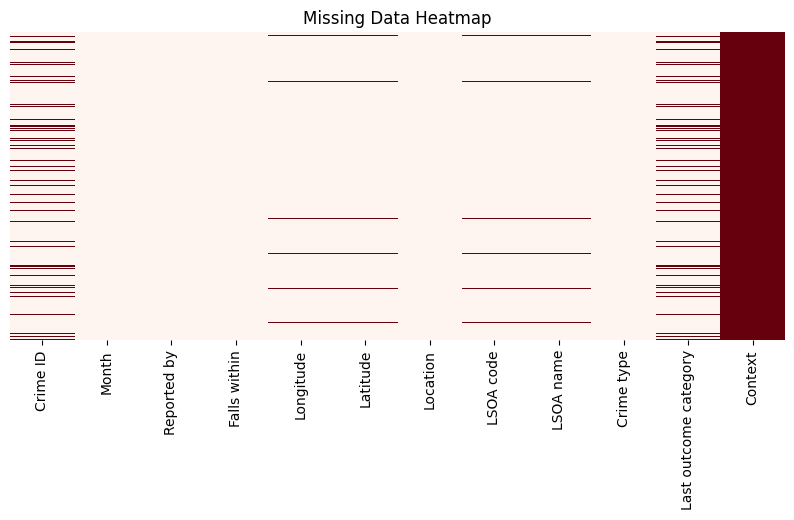

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds", yticklabels=False)
plt.title("Missing Data Heatmap")
plt.show()


<ipython-input-6-0883f2297ba8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crime_counts.values, y=crime_counts.index, palette='viridis')


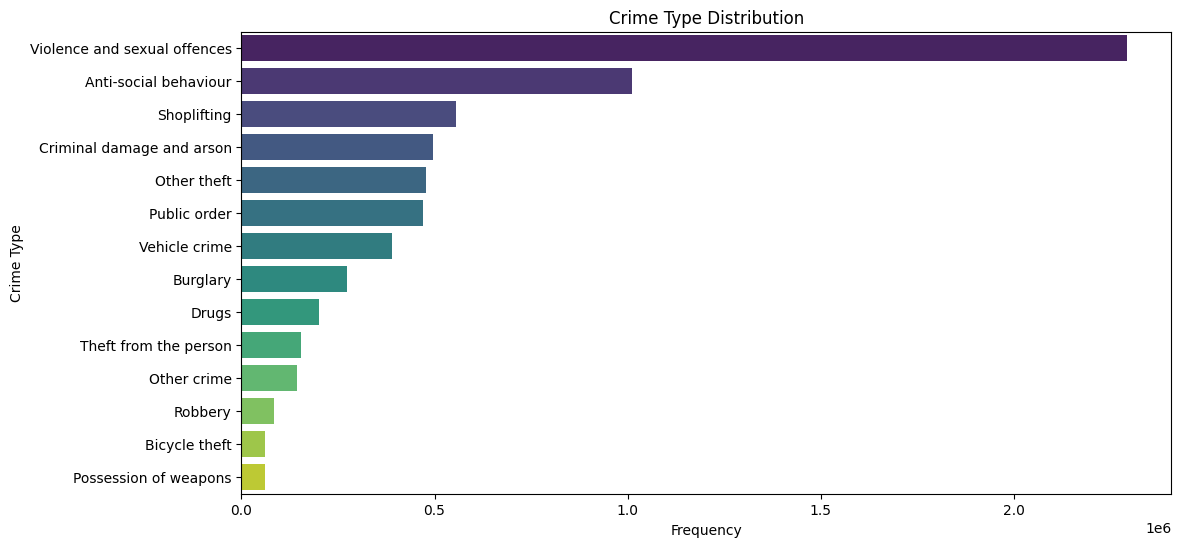

In [ ]:
# Bar chart of crime frequencies
plt.figure(figsize=(12, 6))
crime_counts = df['Crime type'].value_counts().sort_values(ascending=False)
sns.barplot(x=crime_counts.values, y=crime_counts.index, palette='viridis')
plt.title('Crime Type Distribution')
plt.xlabel('Frequency')
plt.ylabel('Crime Type')
plt.show()

<ipython-input-7-05d6e389dd1c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_counts.values, y=location_counts.index, palette='magma')


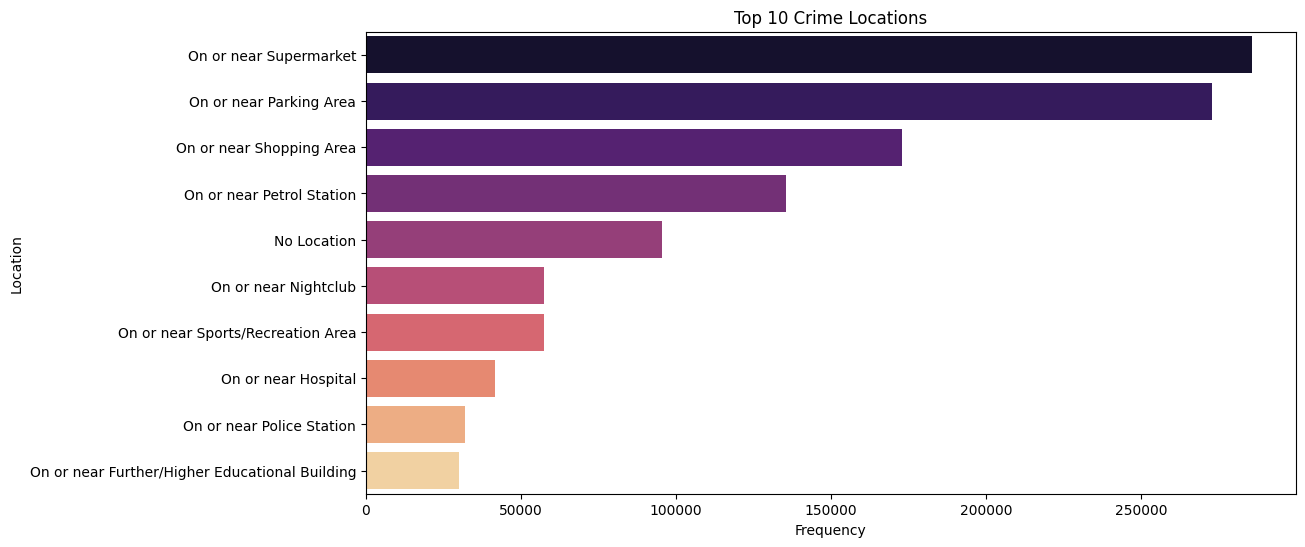

In [ ]:
# Top 10 crime locations
plt.figure(figsize=(12, 6))
location_counts = df['Location'].value_counts().nlargest(10)
sns.barplot(x=location_counts.values, y=location_counts.index, palette='magma')
plt.title('Top 10 Crime Locations')
plt.xlabel('Frequency')
plt.ylabel('Location')
plt.show()

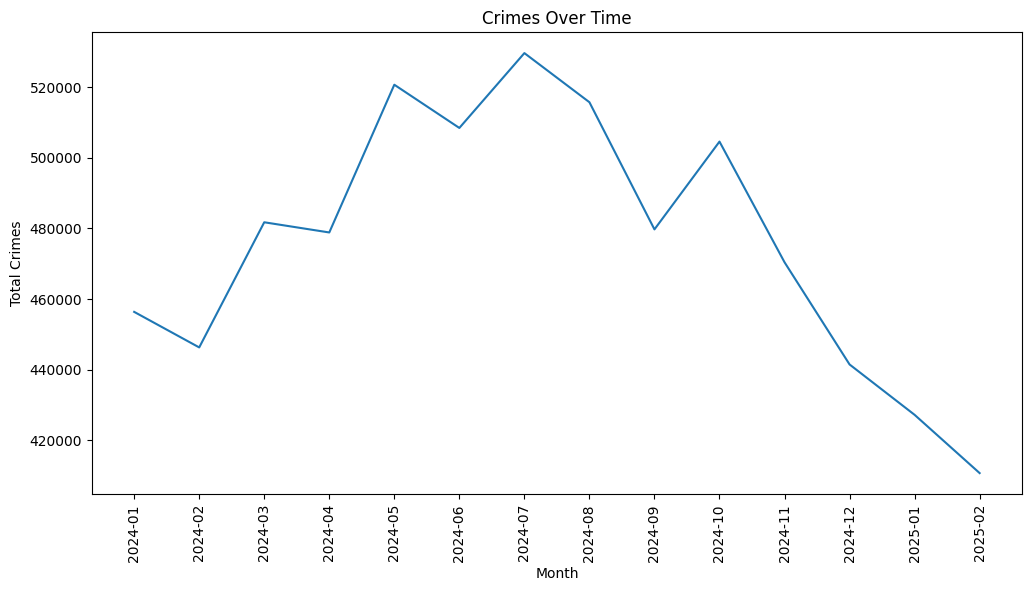

In [ ]:
# Crimes by month (check for future dates)
plt.figure(figsize=(12, 6))
monthly_counts = df['Month'].value_counts().sort_index()
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Crimes Over Time')
plt.xlabel('Month')
plt.ylabel('Total Crimes')
plt.xticks(rotation=90)
plt.show()

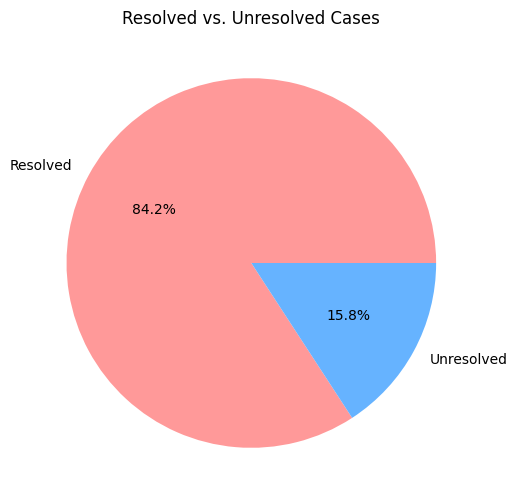

In [ ]:
# Resolved vs. Unresolved
df['Outcome_Status'] = df['Last outcome category'].apply(
    lambda x: 'Unresolved' if pd.isna(x) else 'Resolved'
)
plt.figure(figsize=(8, 6))
outcome_counts = df['Outcome_Status'].value_counts()
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Resolved vs. Unresolved Cases')
plt.show()

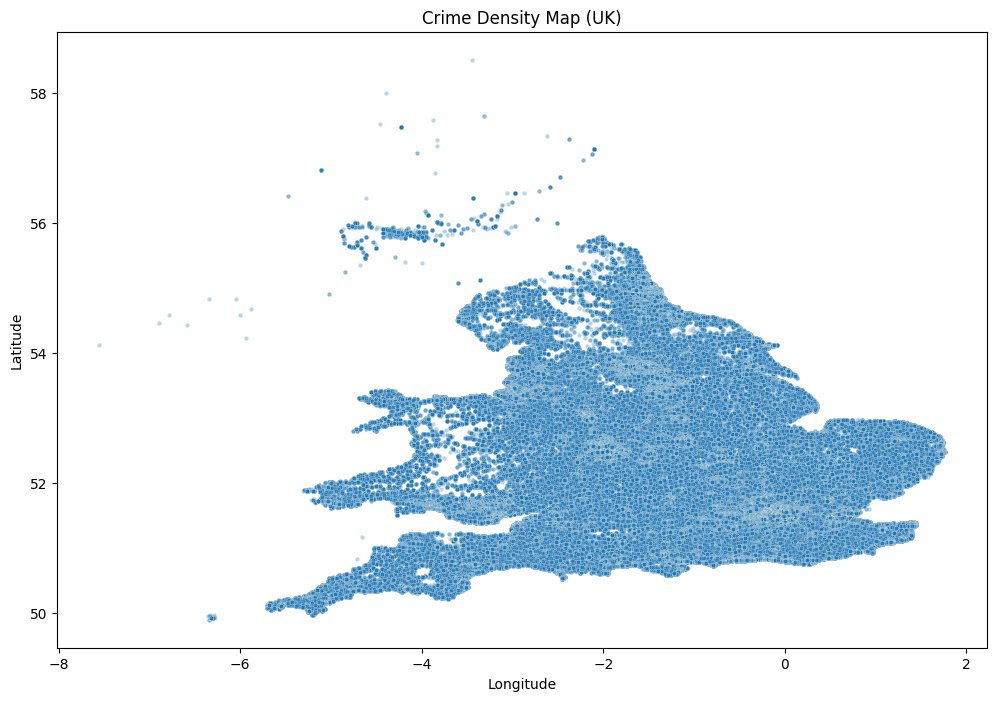

In [ ]:
# Plot crimes with valid coordinates
valid_coords = df.dropna(subset=['Longitude', 'Latitude'])
plt.figure(figsize=(12, 8))
sns.scatterplot(x=valid_coords['Longitude'], y=valid_coords['Latitude'], alpha=0.3, s=10)
plt.title('Crime Density Map (UK)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

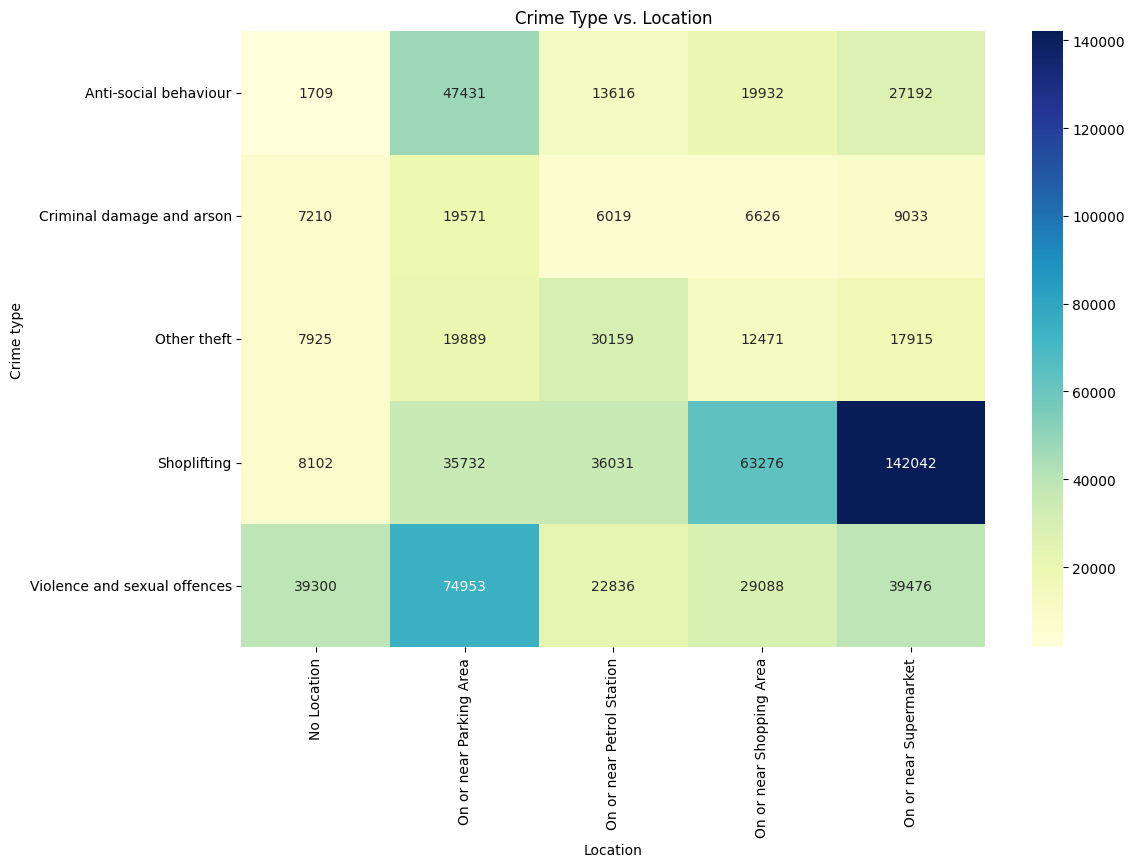

In [ ]:
# Cross-tabulation heatmap (top 5 crimes and locations)
top_crimes = df['Crime type'].value_counts().nlargest(5).index
top_locations = df['Location'].value_counts().nlargest(5).index
cross_tab = pd.crosstab(df[df['Crime type'].isin(top_crimes)]['Crime type'],
                        df[df['Location'].isin(top_locations)]['Location'])
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Crime Type vs. Location')
plt.show()

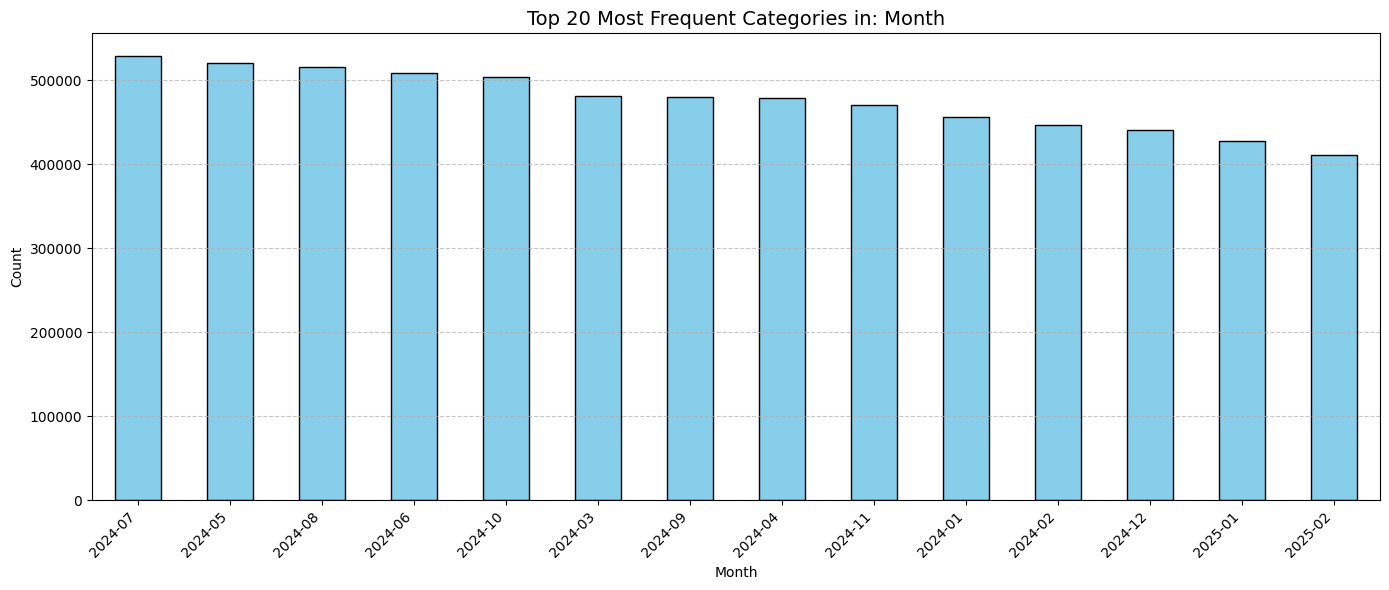

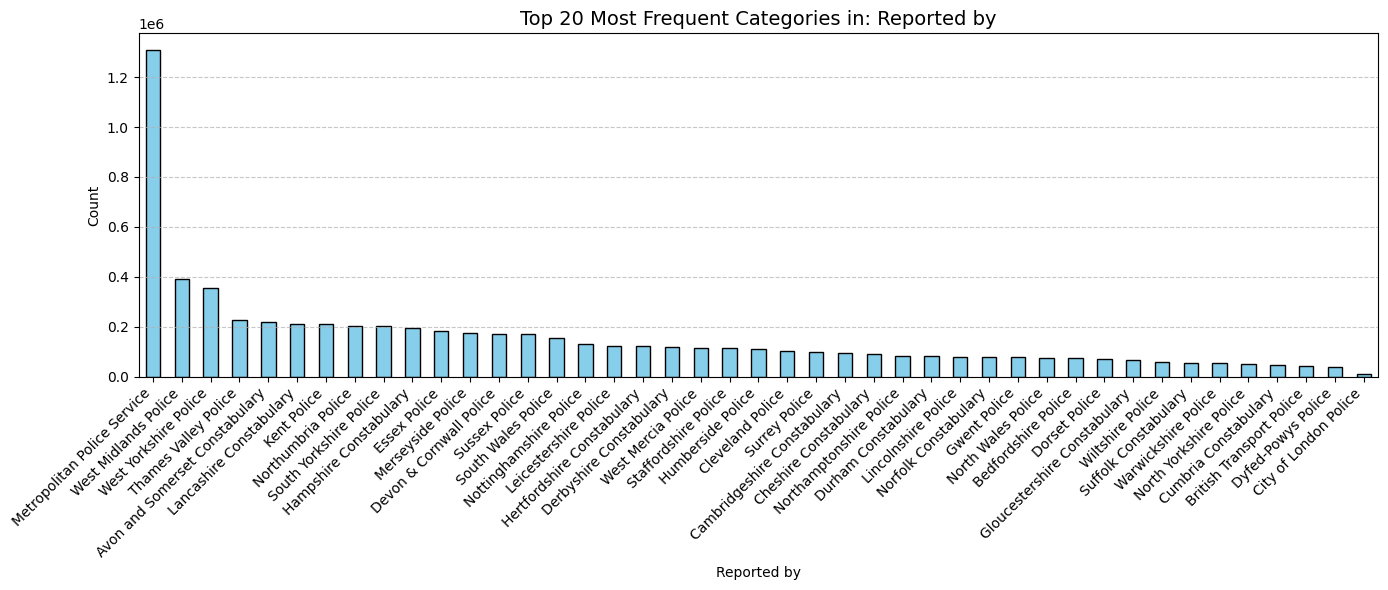

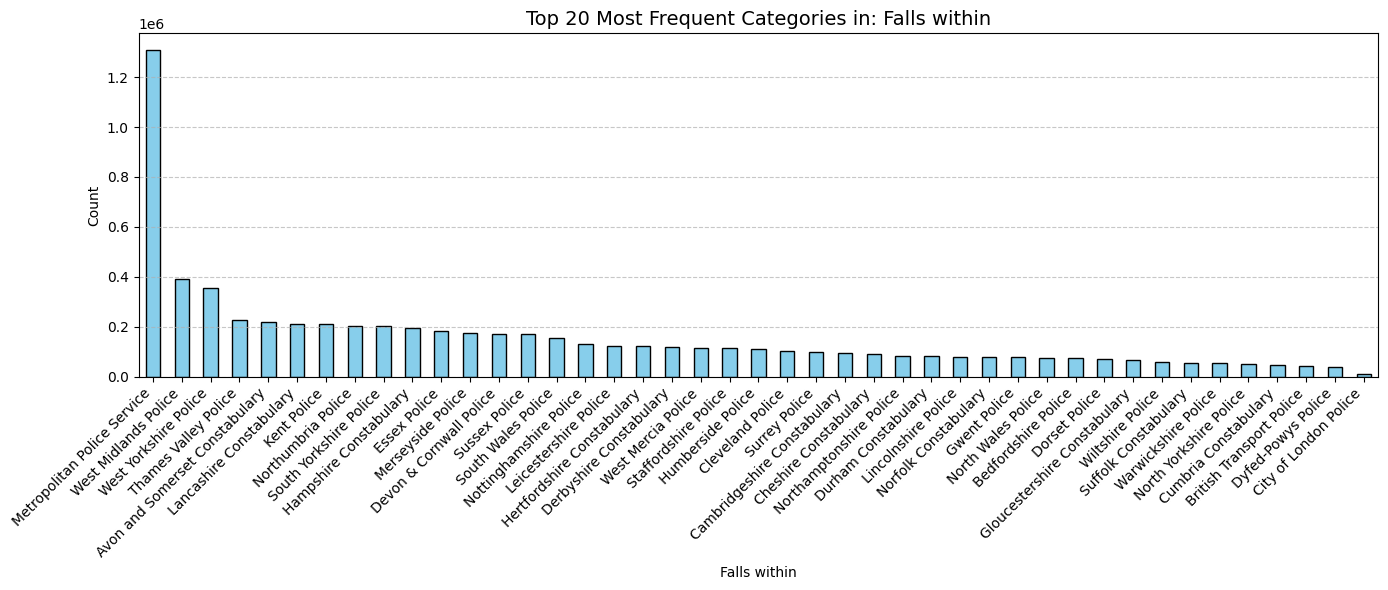

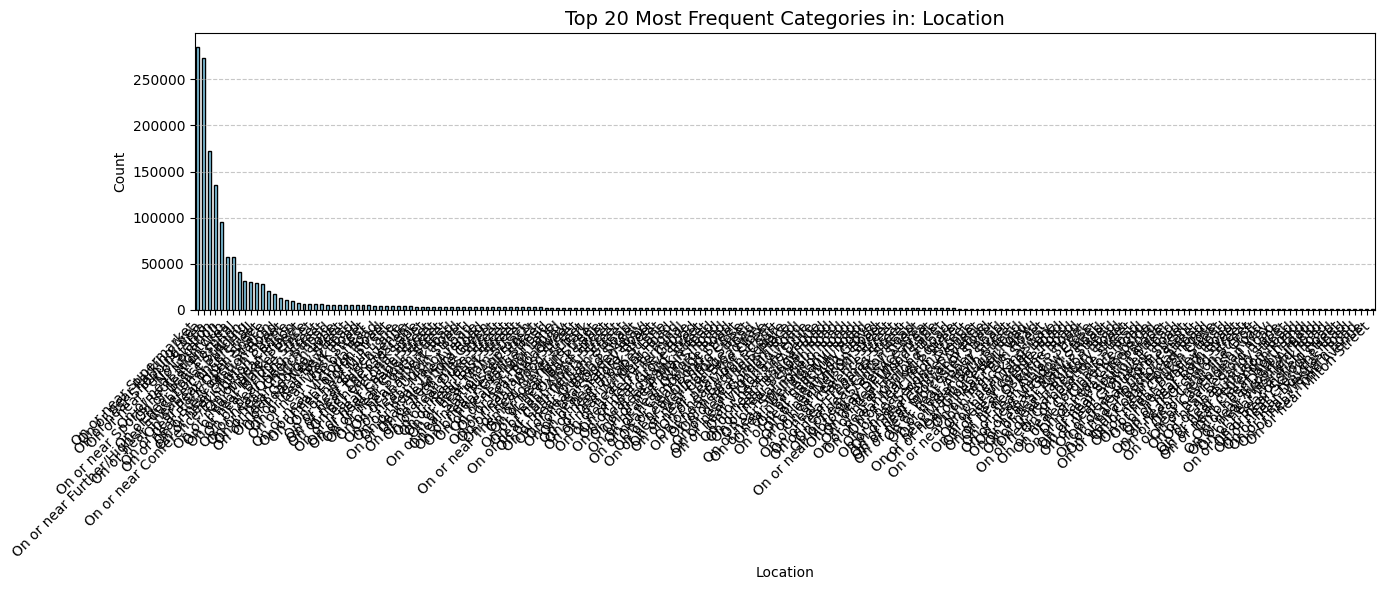

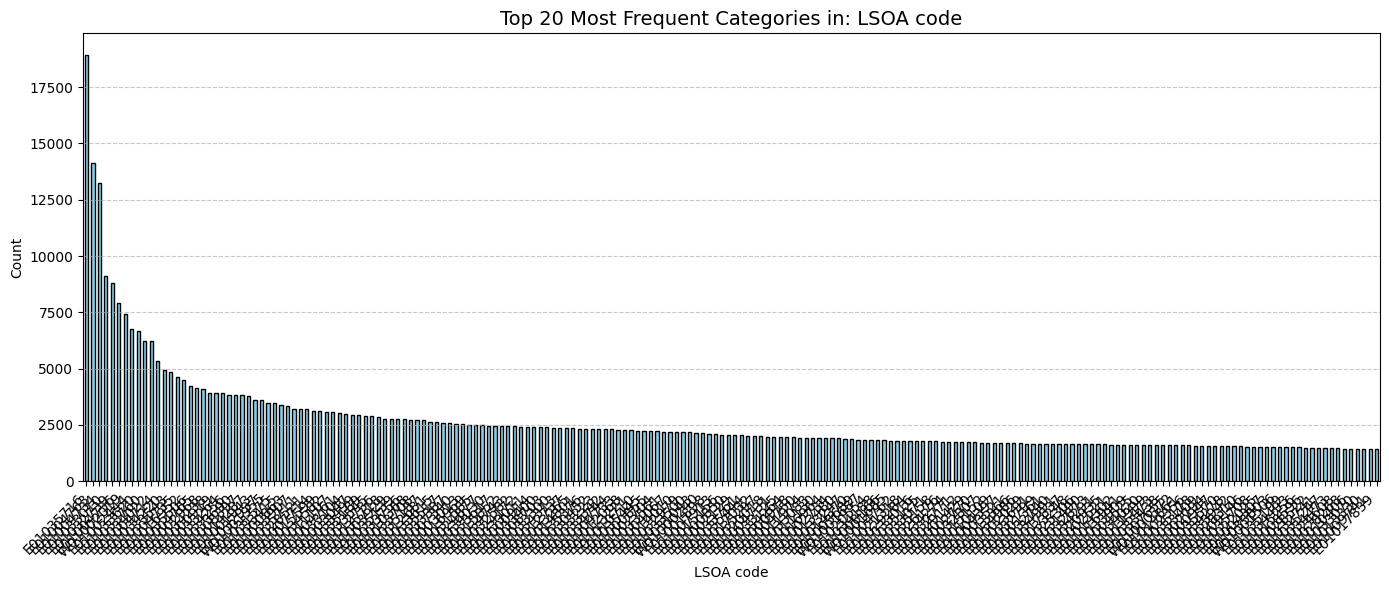

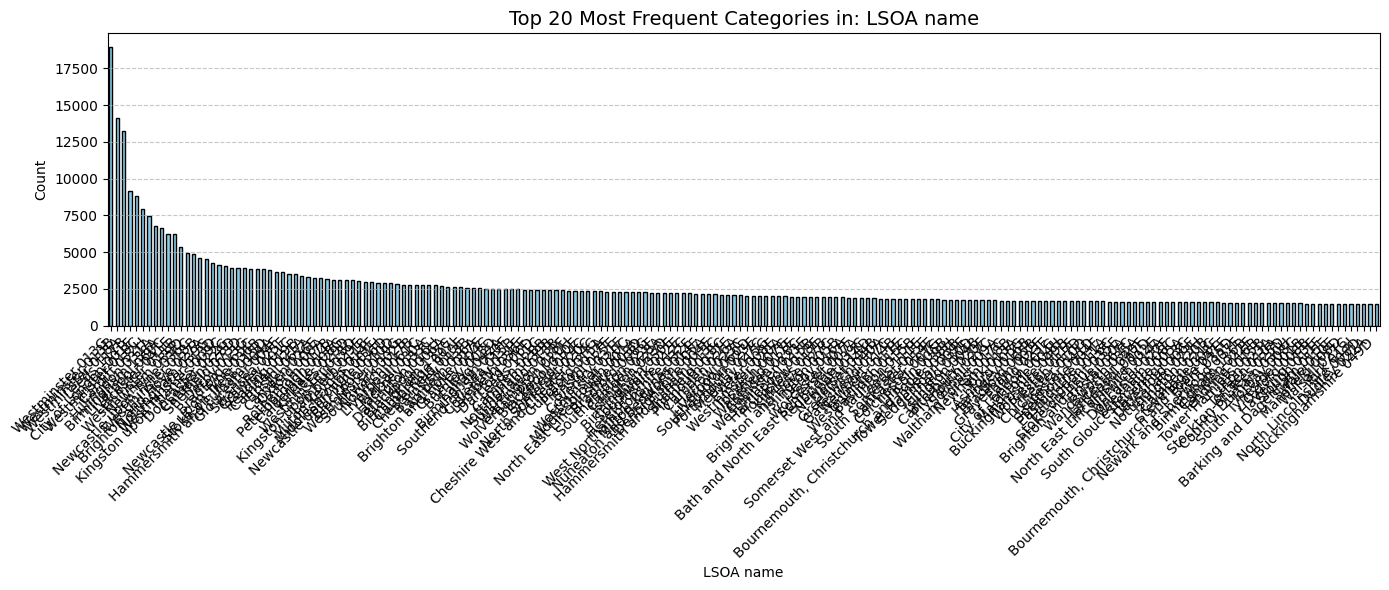

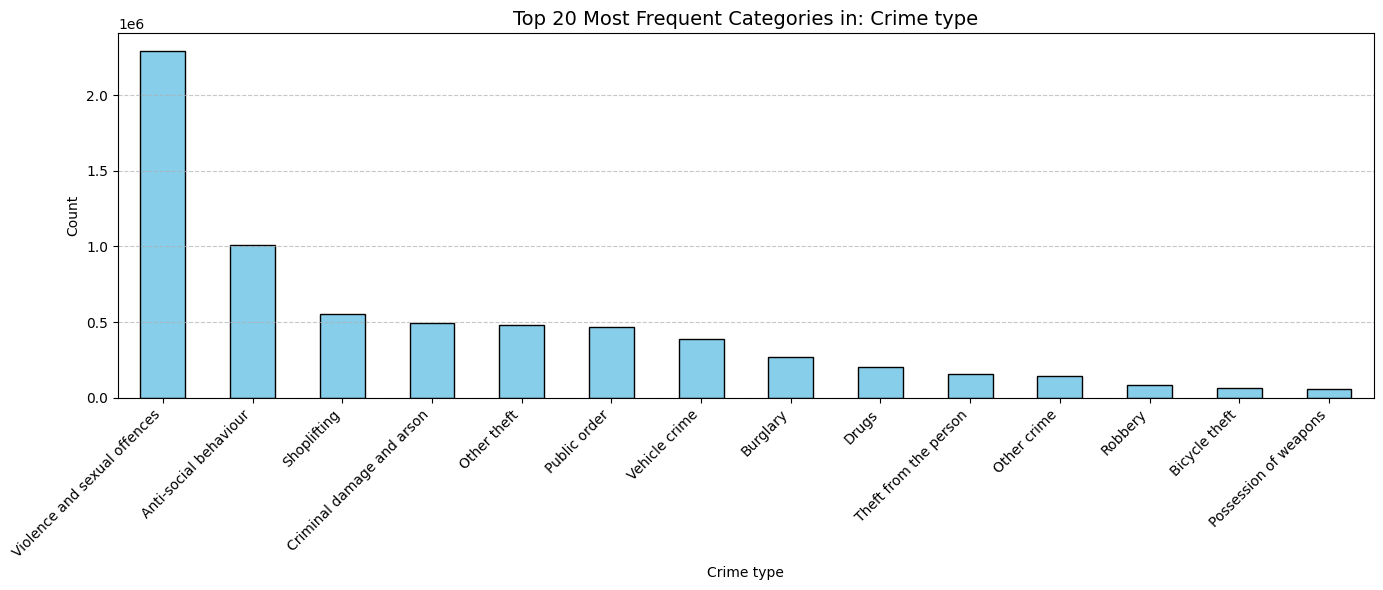

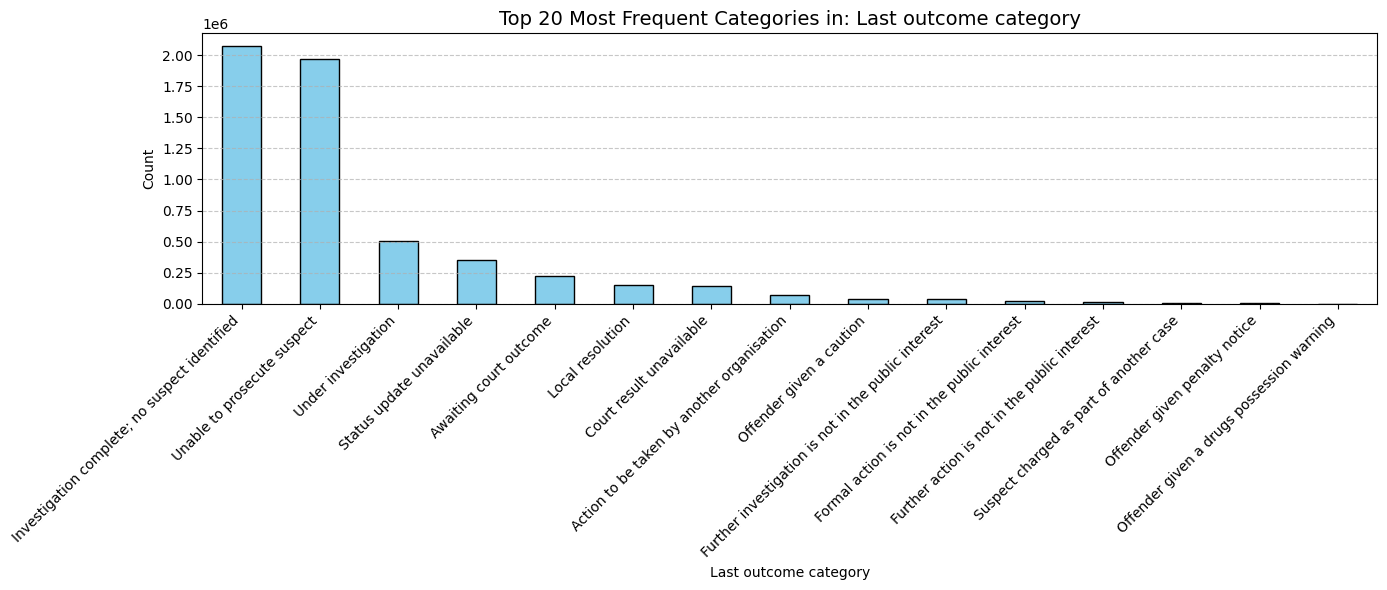

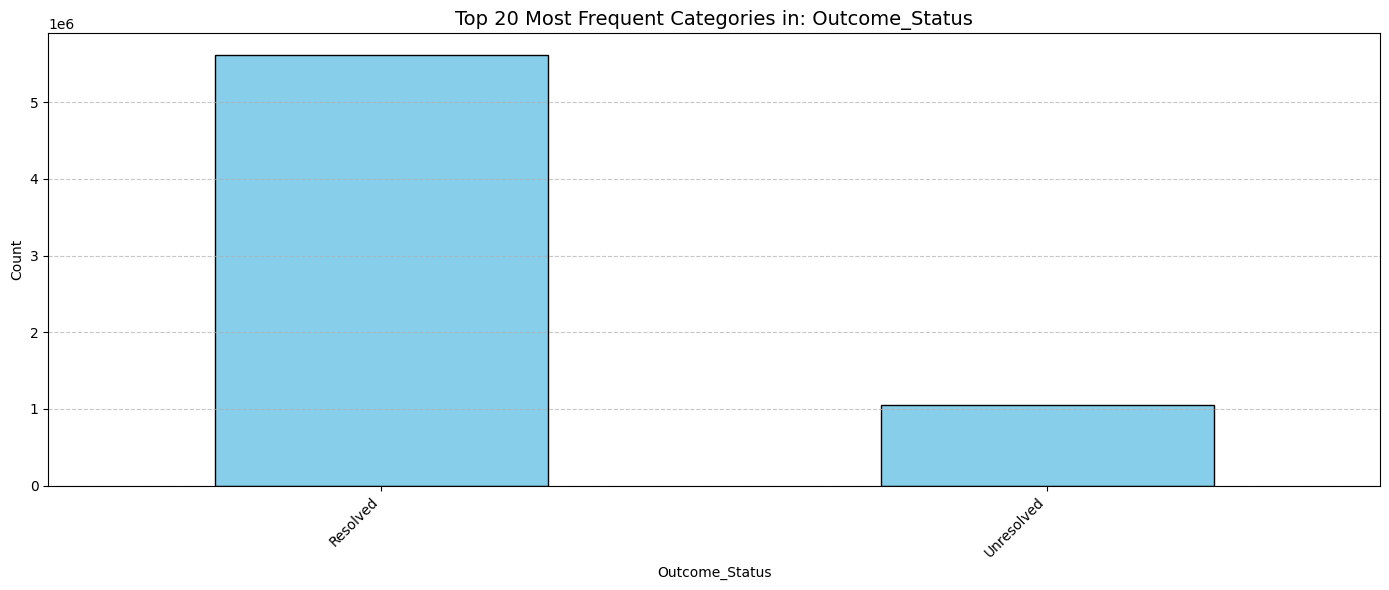

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of ALL your categorical columns (replace with your actual columns)
cat_cols = [
    'Month', 'Reported by', 'Falls within', 'Location',
    'LSOA code', 'LSOA name', 'Crime type',
    'Last outcome category', 'Outcome_Status'  # Remove if doesn't exist
]

# Loop through each categorical column
for col in cat_cols:
    plt.figure(figsize=(14, 6))
    top_values = df[col].value_counts().head(200)
    top_values.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'Top 20 Most Frequent Categories in: {col}', fontsize=14)
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

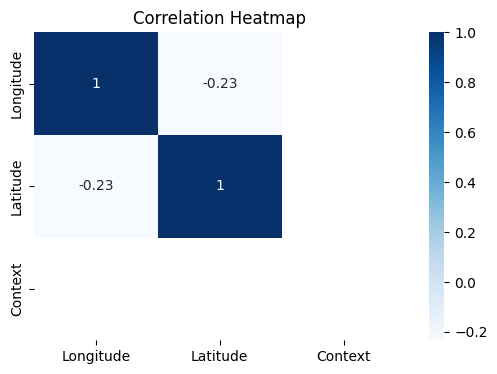

In [ ]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(6, 4))
sns.heatmap(numeric_df.corr(), annot=True, cmap='Blues')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
#Duplicate data
df[df.duplicated(keep=False)]

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome_Status
15,NaN,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.497814,51.415268,On or near Back Lane,E01014400,Bath and North East Somerset 001B,Anti-social behaviour,NaN,NaN,Unresolved
16,NaN,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.499162,51.414948,On or near Ashton Way,E01014400,Bath and North East Somerset 001B,Anti-social behaviour,NaN,NaN,Unresolved
18,NaN,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.497814,51.415268,On or near Back Lane,E01014400,Bath and North East Somerset 001B,Anti-social behaviour,NaN,NaN,Unresolved
19,NaN,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.499162,51.414948,On or near Ashton Way,E01014400,Bath and North East Somerset 001B,Anti-social behaviour,NaN,NaN,Unresolved
37,NaN,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.506810,51.409538,On or near Tintagel Close,E01014401,Bath and North East Somerset 001C,Anti-social behaviour,NaN,NaN,Unresolved
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6671202,NaN,2025-02,Wiltshire Police,Wiltshire Police,-1.793187,51.066936,On or near Ivy Street,E01032023,Wiltshire 059D,Anti-social behaviour,NaN,NaN,Unresolved
6671392,NaN,2025-02,Wiltshire Police,Wiltshire Police,-1.631629,51.238350,On or near Fyfield Way,E01034555,Wiltshire 065E,Anti-social behaviour,NaN,NaN,Unresolved
6671393,NaN,2025-02,Wiltshire Police,Wiltshire Police,-1.631629,51.238350,On or near Fyfield Way,E01034555,Wiltshire 065E,Anti-social behaviour,NaN,NaN,Unresolved
6671420,NaN,2025-02,Wiltshire Police,Wiltshire Police,-1.658268,51.242882,On or near A3026,E01032697,Wiltshire 066C,Anti-social behaviour,NaN,NaN,Unresolved


# Data Cleaning

In [ ]:
# Drop exact duplicates
df_clean = df.drop_duplicates()

# Check results
print(f"Remaining rows after removing duplicates: {len(df_clean)}")
print(f"Remaining duplicates: {df_clean.duplicated().sum()}")

Remaining rows after removing duplicates: 6342788
Remaining duplicates: 0


In [ ]:
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Outcome_Status
0,NaN,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.508867,51.416147,On or near St Francis Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,NaN,NaN,Unresolved
1,40fa64fcde4f3ab53a9037509ba11b08d802e7f4a40ec2...,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.492876,51.422716,On or near Trajectus Way,E01014399,Bath and North East Somerset 001A,Burglary,Status update unavailable,NaN,Resolved
2,823f7f56eec9e7116a2bcc68a69e776a3eac43635cbd10...,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.510162,51.410998,On or near Monmouth Road,E01014399,Bath and North East Somerset 001A,Public order,Unable to prosecute suspect,NaN,Resolved
3,04814c2d4a934074a7e12ebe91fd62ca970c56fe566496...,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.513901,51.418814,On or near Stockwood Hill,E01014399,Bath and North East Somerset 001A,Vehicle crime,Status update unavailable,NaN,Resolved
4,ad0c54d884107cd906600f4112f057b03176190fbedf80...,2024-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511746,51.409957,On or near Caernarvon Close,E01014399,Bath and North East Somerset 001A,Violence and sexual offences,Unable to prosecute suspect,NaN,Resolved


In [ ]:
# Columns to remove (justify each):
to_drop = [
    'Context',           # >99% missing (useless)
    'Crime ID',          # Random unique IDs
    'Reported by',       # All same value ("Avon and Somerset Constabulary")
    'LSOA name'          # Redundant with 'LSOA code'
]

# Execute removal (keeping original as backup)
df_clean = df_clean.drop(columns=to_drop, errors='ignore')

# Verify
print("✅ Columns removed. New shape:", df_clean.shape)
print("Remaining columns:", df_clean.columns.tolist())

✅ Columns removed. New shape: (6342788, 9)
Remaining columns: ['Month', 'Falls within', 'Longitude', 'Latitude', 'Location', 'LSOA code', 'Crime type', 'Last outcome category', 'Outcome_Status']


In [ ]:
print(f"Remaining duplicates: {df_clean.duplicated().sum()}")

Remaining duplicates: 1209292


In [ ]:
# Define key identifying columns (without Crime ID)
key_columns = [
    'Month',
    'Longitude',
    'Latitude',
    'Location',
    'LSOA code',
    'Crime type',
    'Last outcome category'
]

# Remove duplicates based on REMAINING columns
df_clean = df_clean.drop_duplicates(subset=key_columns, keep='first')

# Verify
print(f"Final duplicates: {df_clean.duplicated().sum()}")  # Should now be 0

Final duplicates: 0


In [ ]:
# Clean all columns where NaN or empty
df_clean.dropna(axis=1, how='all', inplace=True)

In [ ]:
# Remove on a near as it's redundant
df_clean['Location'] = df_clean['Location'].str.replace('On or near ', '')

In [ ]:
# Handle both NaN and empty strings gracefully
df_clean['Location_type'] = df_clean['Location'].apply(
    lambda x: x.split()[-1] if isinstance(x, str) and x.strip() else 'Unknown'
)

In [ ]:
print(f"Final duplicates: {df_clean.duplicated().sum()}")

Final duplicates: 0


In [ ]:
df_clean.head()

,Month,Falls within,Longitude,Latitude,Location,LSOA code,Crime type,Last outcome category,Outcome_Status,Location_type
0,2024-01,Avon and Somerset Constabulary,-2.508867,51.416147,St Francis Road,E01014399,Anti-social behaviour,NaN,Unresolved,Road
1,2024-01,Avon and Somerset Constabulary,-2.492876,51.422716,Trajectus Way,E01014399,Burglary,Status update unavailable,Resolved,Way
2,2024-01,Avon and Somerset Constabulary,-2.510162,51.410998,Monmouth Road,E01014399,Public order,Unable to prosecute suspect,Resolved,Road
3,2024-01,Avon and Somerset Constabulary,-2.513901,51.418814,Stockwood Hill,E01014399,Vehicle crime,Status update unavailable,Resolved,Hill
4,2024-01,Avon and Somerset Constabulary,-2.511746,51.409957,Caernarvon Close,E01014399,Violence and sexual offences,Unable to prosecute suspect,Resolved,Close


In [ ]:
df_clean.drop(columns=['Location'], inplace=True)

In [ ]:
print("\nMissing Values:\n", df_clean.isnull().sum())


Missing Values:
 Month                         0
Falls within                  0
Longitude                  1550
Latitude                   1550
LSOA code                  2984
Crime type                    0
Last outcome category    728505
Outcome_Status                0
Location_type                 0
dtype: int64


In [ ]:
print(f"Remaining duplicates: {df_clean.duplicated().sum()}")

Remaining duplicates: 0


In [ ]:
# Fill categorical columns
df_clean['LSOA code'] = df_clean['LSOA code'].fillna('Unknown')
df_clean['Last outcome category'] = df_clean['Last outcome category'].fillna('Unknown')

# Drop rows with missing coordinates (small fraction only ~0.03%)
df_clean.dropna(subset=['Longitude', 'Latitude'], inplace=True)

In [ ]:
print("\nMissing Values:\n", df_clean.isnull().sum())


Missing Values:
 Month                    0
Falls within             0
Longitude                0
Latitude                 0
LSOA code                0
Crime type               0
Last outcome category    0
Outcome_Status           0
Location_type            0
dtype: int64


In [ ]:
df_clean.shape

(5115954, 9)

In [ ]:
df_clean['Year'] = df_clean['Month'].str[:4].astype(int)
df_clean['Month_num'] = df_clean['Month'].str[-2:].astype(int)
df_clean = df_clean.drop('Month', axis=1)

In [ ]:
# Reorder columns (optional)
new_order = ['Year', 'Month_num'] + [col for col in df_clean.columns if col not in ['Year', 'Month_num']]
df_clean = df_clean[new_order]

In [ ]:
# Resolved vs. Unresolved
df_clean['Outcome_Status'] = df_clean['Last outcome category'].apply(
    lambda x: 'Unresolved' if pd.isna(x) else 'Resolved'
)

In [ ]:
# 1. Extract Higher-Level Geography (Best Balance)
df_clean['LSOA_group'] = df_clean['Falls within'] + '_' + df_clean['LSOA code'].str[:4]

# 2. Alternative: Police Force + LSOA Prefix (For Resource Allocation)
# df_clean['LSOA_group'] = df_clean['Falls within'] + '_' + df_clean['LSOA code'].str[:3]

# 3. Verify grouping
print(f"Reduced from {df_clean['LSOA code'].nunique()} to {df_clean['LSOA_group'].nunique()} groups")
print(df_clean['LSOA_group'].value_counts().head(10))

Reduced from 34404 to 80 groups
LSOA_group
Metropolitan Police Service_E010       933090
West Midlands Police_E010              300837
West Yorkshire Police_E010             279803
Thames Valley Police_E010              180369
Kent Police_E010                       163531
Lancashire Constabulary_E010           161694
Hampshire Constabulary_E010            159227
Avon and Somerset Constabulary_E010    157203
Northumbria Police_E010                154860
South Yorkshire Police_E010            151686
Name: count, dtype: int64


In [ ]:
# Create cyclical features
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['Month_num'] / 12)  # Captures "position" in the year
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['Month_num'] / 12)  # Captures "distance" from start

# Optional: Drop the original Month_num (now redundant)
df_clean = df_clean.drop(columns=['Month_num'])

In [ ]:
df_clean['Lat_bin'] = df_clean['Latitude'].round(2)
df_clean['Lon_bin'] = df_clean['Longitude'].round(2)
df_clean['coord_group'] = df_clean['Lat_bin'].astype(str) + '_' + df_clean['Lon_bin'].astype(str)

# Step 3: Encode coord_group as categorical
from sklearn.preprocessing import LabelEncoder
coord_label_encoder = LabelEncoder()
df_clean['coord_group_encoded'] = coord_label_encoder.fit_transform(df_clean['coord_group'])

# Save the encoder
with open("coord_encoder.pkl", "wb") as f:
    pickle.dump(coord_label_encoder, f)

# Optional: Drop raw Lat/Lon
df_clean.drop(columns=['Latitude', 'Longitude', 'Lat_bin', 'Lon_bin', 'coord_group'], inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_clean["Crime_encoded"] = label_encoder.fit_transform(df_clean["Crime type"])

# Save the encoder for later (e.g., with pickle)
import pickle
with open("crime_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [ ]:
last_outcome = df_clean["Last outcome category"].nunique()
print(f"Number of unique categories in 'Last outcome category': {last_outcome}")

falls_within = df_clean["Falls within"].nunique()
print(f"Number of unique categories in 'Falls within': {falls_within}")

Number of unique categories in 'Last outcome category': 16
Number of unique categories in 'Falls within': 43


In [ ]:
df_clean.drop(columns=["Falls within"], inplace=True)

In [ ]:
df_clean.drop(columns=["LSOA code"], inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Columns to encode
columns_to_encode = [
    "Crime type",
    "Last outcome category",
    "Outcome_Status",
    "Location_type",
    "LSOA_group"
]


# Encode and save label encoders
for col in columns_to_encode:
    encoder = LabelEncoder()
    df_clean[f"{col.replace(' ', '_')}_encoded"] = encoder.fit_transform(df_clean[col])

    # Save encoder
    with open(f"{col.replace(' ', '_')}_encoder.pkl", "wb") as f:
        pickle.dump(encoder, f)

# Drop only the requested columns
#df_clean.drop(columns=columns_to_drop, inplace=True)


In [ ]:
df_clean.drop(columns=["Crime type","Last outcome category","Outcome_Status","Location_type","LSOA_group"], inplace=True)

In [ ]:
last_outcome1 = df_clean["Location_type_encoded"].nunique()
print(f"Number of unique categories in 'Last outcome category': {last_outcome1}")

Number of unique categories in 'Last outcome category': 19004


In [ ]:
df_clean.drop(columns=["Crime_encoded"], inplace=True)

In [ ]:
df_clean.head()

,Year,Month_sin,Month_cos,coord_group_encoded,Crime_type_encoded,Last_outcome_category_encoded,Outcome_Status_encoded,Location_type_encoded,LSOA_group_encoded
0,2024,0.5,0.866025,17519,0,15,0,15265,0
1,2024,0.5,0.866025,17517,2,11,0,18157,0
2,2024,0.5,0.866025,17240,8,13,0,15265,0
3,2024,0.5,0.866025,17519,12,11,0,10377,0
4,2024,0.5,0.866025,17240,13,13,0,5997,0


In [ ]:
df_clean.shape

(5115954, 9)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Sample only first 1M rows
#f_sample = df_clean.head(100000)
df_sample = df_clean

# Ensure target is not in feature set
target_col = "Crime_type_encoded"
X = df_sample.drop(columns=[target_col])
y = df_sample[target_col]

# Check for accidental leakage
assert target_col not in X.columns

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=y.nunique(),
    eval_metric='mlogloss',
)

xgb_model.fit(X_train, y_train)

# Evaluation
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    138229
           1       0.20      0.01      0.03     11308
           2       0.23      0.01      0.01     49642
           3       0.23      0.16      0.19     88960
           4       0.55      0.24      0.33     35305
           5       0.52      0.04      0.07     25786
           6       0.23      0.08      0.12     78473
           7       0.62      0.00      0.00     11298
           8       0.19      0.01      0.01     82000
           9       0.00      0.00      0.00     15354
          10       0.37      0.27      0.31     54282
          11       0.23      0.20      0.21     18726
          12       0.24      0.44      0.31     69155
          13       0.50      0.87      0.64    344673

    accuracy                           0.50   1023191
   macro avg       0.37      0.24      0.23   1023191
weighted avg       0.45      0.50      0.43   1023191



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#save model
with open("crime_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

In [ ]:
import shutil
import os

# Define source (Colab working directory) and destination (your Drive folder)
source_dir = "/content/"
target_dir = "/content/drive/MyDrive/CMP7161/datasets/"

# Loop through all .pkl files and copy them to Drive
for filename in os.listdir(source_dir):
    if filename.endswith(".pkl"):
        shutil.copy(os.path.join(source_dir, filename), os.path.join(target_dir, filename))
